In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

# Do not show warning in the output
import warnings
warnings.filterwarnings('ignore')

# display all outputs without having to inclue a print statement
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# make screen wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [15]:
def count_histogram(df, bins=16, save=False):
    
    x_label = '$M_{\star} [\log(M_{\u2609})]$'
    y_label = 'Number of halos'
    
    h = 0.6774
    lower_bound = 6.0
    upper_bound = 8.3
    narrowing_factor = 4.5 # For setting the bar width in the plot
    
    labelsize = 50
    legendsize = 35
    axis_width = 4
    linewidth = 4
    tick_size_major = 16
    tick_size_minor = 8
    tick_width_major = 4
    tick_width_minor = 3
    tick_label_size = 35
    figsize_x = 20
    figsize_y = 15

    df_z6 = df[df.z==6]
    df_z8 = df[df.z==8]
    df_z10 = df[df.z==10]

    log_masses_z6 = np.log10(df_z6['StarMass'])
    log_masses_z8 = np.log10(df_z8['StarMass'])
    log_masses_z10 = np.log10(df_z10['StarMass'])

    edges = np.linspace(lower_bound, upper_bound, bins)
    binning_width = edges[1]-edges[0]
    bar_width = binning_width/narrowing_factor

    _ = plt.hist(log_masses_z6, bins=edges-bar_width, width = bar_width, label='z=6')
    _ = plt.hist(log_masses_z8+bar_width, bins=edges, width = bar_width, label='z=8')
    _ = plt.hist(log_masses_z10+2*bar_width, bins=edges+bar_width, width = bar_width, label='z=10')
    
    #plt.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.rc('xtick', labelsize=tick_label_size) 
    plt.rc('ytick', labelsize=tick_label_size) 
    plt.xlabel(x_label, fontsize=labelsize)
    plt.ylabel(y_label, fontsize=labelsize)
    plt.rcParams["figure.figsize"] = (figsize_x,figsize_y)
    plt.rc('axes', linewidth=axis_width)
    plt.tick_params(length=tick_size_major, width=tick_width_major)
    plt.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    plt.legend(fontsize = legendsize)
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/halo_counts.pdf', bbox_inches = 'tight')
    return

In [3]:
def plot_scatter(df, save=False):
    
    x_label = '$M_{\star}[\log(M_{\u2609})]$'
    y_label = '$\log(Q_{0})[\mathrm{s}^{-1}]$'
    #x_label = 'SFR'
    
    h = 0.6774
    lower_bound = 5.7
    upper_bound = 9.3
    narrowing_factor = 4.5 # For setting the bar width in the plot
    
    labelsize = 50
    legendsize = 35
    axis_width = 4
    linewidth = 4
    tick_size_major = 16
    tick_size_minor = 8
    tick_width_major = 4
    tick_width_minor = 3
    tick_label_size = 35
    figsize_x = 20
    figsize_y = 15

    df_z6 = df[df.z==6]
    df_z8 = df[df.z==8]
    df_z10 = df[df.z==10]

    _ = plt.scatter(np.log10(df_z6['StarMass']), np.log10(df_z6['Q0']), label='z=6')
    _ = plt.scatter(np.log10(df_z8['StarMass']), np.log10(df_z8['Q0']), label='z=8')
    _ = plt.scatter(np.log10(df_z10['StarMass']), np.log10(df_z10['Q0']), label='z=10')

#     _ = plt.scatter(np.log10(df_z6['SFR']), np.log10(df_z6['Q0']), label='z=6')
#     _ = plt.scatter(np.log10(df_z8['SFR']), np.log10(df_z8['Q0']), label='z=8')
#     _ = plt.scatter(np.log10(df_z10['SFR']), np.log10(df_z10['Q0']), label='z=10')
    
    #plt.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.rc('xtick', labelsize=tick_label_size) 
    plt.rc('ytick', labelsize=tick_label_size) 
    plt.xlabel(x_label, fontsize=labelsize)
    plt.ylabel(y_label, fontsize=labelsize)
    plt.rcParams["figure.figsize"] = (figsize_x,figsize_y)
    plt.rc('axes', linewidth=axis_width)
    plt.tick_params(length=tick_size_major, width=tick_width_major)
    plt.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    plt.legend(fontsize = legendsize)
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/all_data_scatter.pdf', bbox_inches = 'tight')
    return

In [4]:
def update_df(df):
    h = 0.6774
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    return

In [5]:
df = pd.read_pickle('dfs/esc_analysis.pickle')
update_df(df)

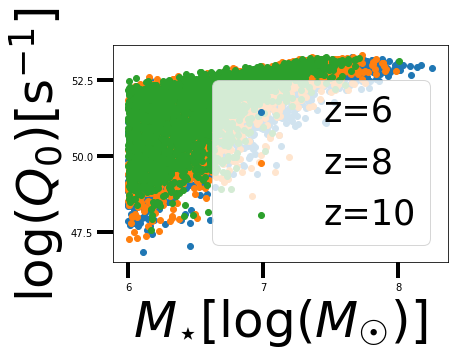

In [6]:
plot_scatter(df, save=True)

In [14]:
np.min(df['StarMass'])/1e6

1.000117108310788

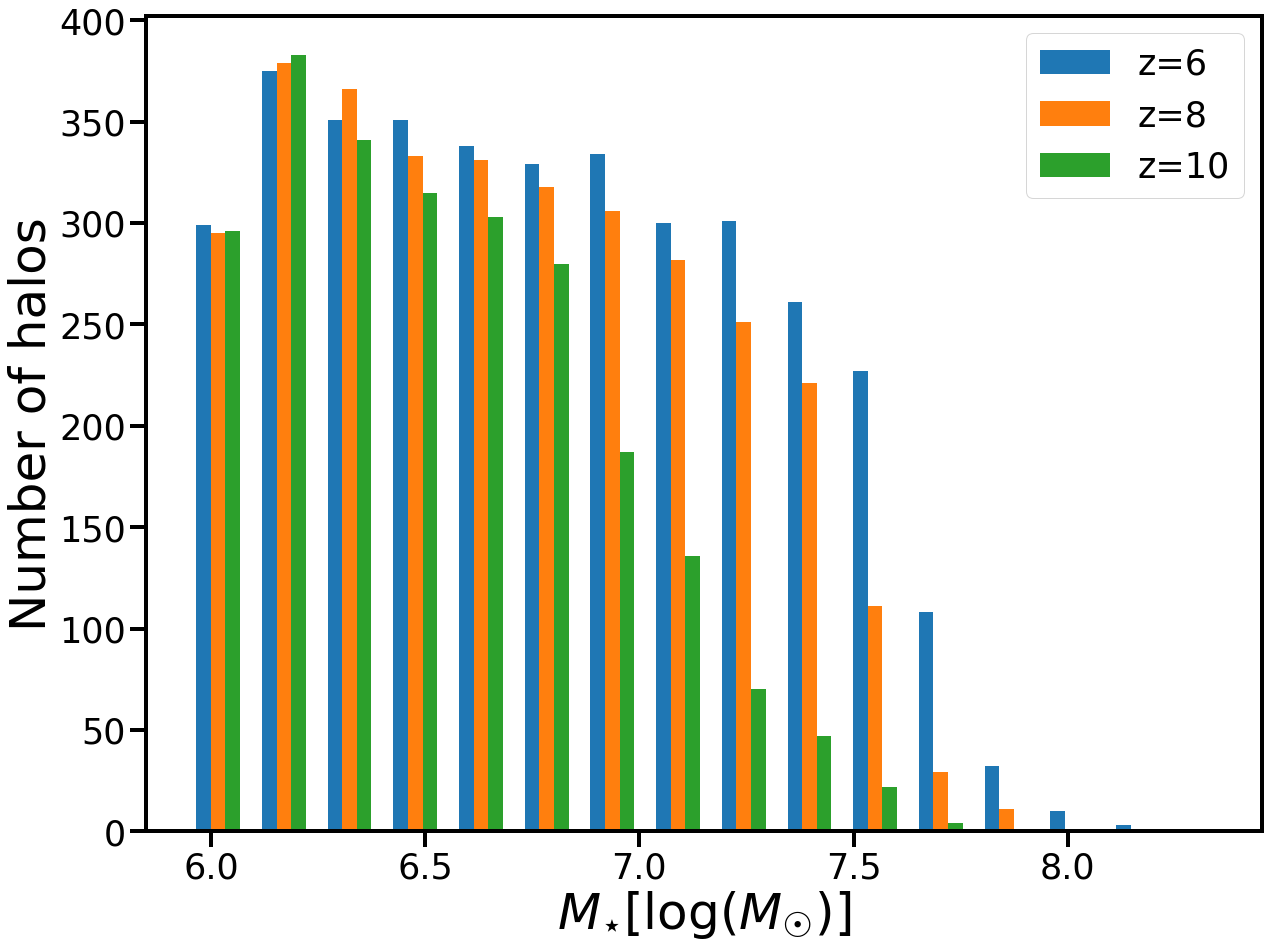

In [16]:
count_histogram(df, save=True)

In [16]:
df_test = pd.read_pickle('df_no_dust.pickle')
update_df(df_test)

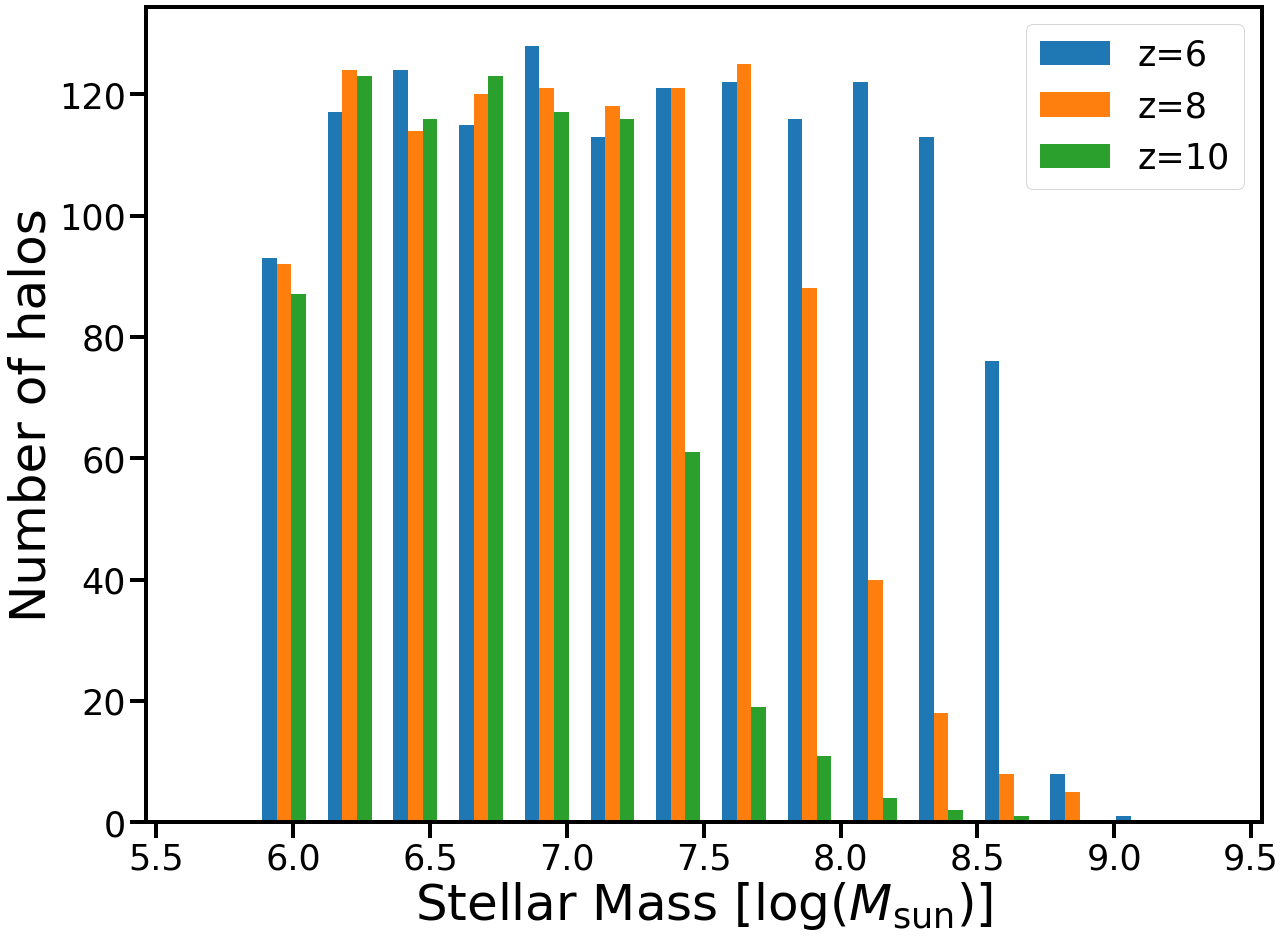

In [22]:
count_histogram(df_test)

In [24]:
intersection = pd.merge(df, df_test, how ='inner', left_index=True, right_index=True) 

In [25]:
l

,ID_x,z_x,HaloMass_x,Metallicity_x,FractionStars_x,FractionGas_x,FractionDust_x,Q0_x,aStar,HaloRadii_x,...,escaped_photons_y,frequencies_y,n_iterations_y,per_freq_0_2,per_source_0_2,emitted_photons_0_2,escaped_photons_0_2,frequencies_0_2,n_iterations_0_2,StarMass_y
0,7085,6,0.464397,0.001652,0.002138,0.089609,0.000022,6.795807e+51,2.142119e+08,38.012012,...,"[[6.685515680411676e-284, 5.523085474821684e-1...","[3288593900000000.0, 3290420400000000.5, 32939...",2,"[0.040649326065812307, 0.045509134402807065, 0...","[7.230333050506903e-11, 7.182235310122338e-12,...","[[2.1882911418039955e-05, 0.8423052396400053, ...","[[2.968401673955691e-267, 6.125548456771468e-1...","[3288593900000000.0, 3290420400000000.5, 32939...",2,9.928758e+06
1,13062,6,0.292090,0.001163,0.000917,0.069116,0.000009,1.292940e+52,2.398404e+08,32.647167,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3288593900000000.0, 3290420400000000.5, 32939...",2,"[0.01662303979213229, 0.017010109698792606, 0....","[3.81398326886323e-137, 1.8245925347721112e-12...","[[0.0027170884254581577, 0.002684182407393514,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3288593900000000.0, 3290420400000000.5, 32939...",2,2.368917e+08
2,29181,6,0.151621,0.001102,0.000821,0.059893,0.000010,3.266608e+49,2.486726e+08,25.852867,...,"[[0.0, 7.547327433305561e-109, 0.0, 0.0, 0.0, ...","[3288593900000000.0, 3290420400000000.5, 32939...",2,"[5.419590066739419e-22, 4.822512334178068e-22,...","[1.0242437096069015e-12, 2.477742829821818e-11...","[[0.0016057233696996644, 0.002519031280048357,...","[[0.0, 4.1307930504363134e-101, 0.0, 0.0, 0.0,...","[3288593900000000.0, 3290420400000000.5, 32939...",3,2.679525e+06
3,2918,6,0.899101,0.000992,0.001881,0.101950,0.000021,8.177726e+52,1.968559e+08,48.933620,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 5.065837436335784e-...","[3288593900000000.0, 3290420400000000.5, 32939...",2,"[0.0002643140137740995, 0.0002791383356098841,...","[1.019289684119516e-09, 2.6182635235796157e-11...","[[0.00011631226612545733, 0.001260740708055142...","[[0.0, 0.0, 0.0, 0.0, 0.0, 6.739160860268474e-...","[3288593900000000.0, 3290420400000000.5, 32939...",2,1.245377e+06
4,1360,6,1.568134,0.001754,0.002931,0.112949,0.000033,1.222487e+53,2.000440e+08,59.073738,...,"[[0.0, 0.0, 0.0, 1.7310105291953283e-88, 2.826...","[3288593900000000.0, 3290420400000000.5, 32939...",2,"[0.11447141640984881, 0.12455466403475726, 0.1...","[2.6777527879992228e-11, 8.050931114918518e-12...","[[3.818944583012315e-05, 0.0001708876331994398...","[[0.0, 0.0, 5.778888678867098e-208, 2.33091186...","[3288593900000000.0, 3290420400000000.5, 32939...",2,1.691648e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,4276,10,0.125761,0.000572,0.001105,0.045173,0.000010,2.351480e+52,8.839289e+07,24.423958,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3288593900000000.0, 3290420400000000.5, 32939...",2,"[0.201459724828863, 0.22663259668393215, 0.254...","[1.8531017872179733e-13, 8.510667689651856e-11...","[[0.0002491043423266277, 0.0001409381869297116...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3288593900000000.0, 3290420400000000.5, 32939...",2,1.573228e+07
3119,256,10,0.604882,0.000296,0.001050,0.041900,0.000006,3.441501e+52,1.036131e+08,32.196342,...,"[[0.01657277705624605, 0.0, 0.0, 2.27437357042...","[3288593900000000.0, 3290420400000000.5, 32939...",2,"[0.07005549608719208, 0.0650996064578909, 0.06...","[0.2550604511440252, 1.1052922040535673e-09, 4...","[[0.5090211871587933, 0.00012202694243262935, ...","[[0.08632400013231667, 0.0, 0.0, 8.30645690907...","[3288593900000000.0, 3290420400000000.5, 32939...",2,2.132396e+06
3120,121,10,0.889497,0.000797,0.001609,0.070277,0.000016,9.133150e+52,9.264010e+07,44.479710,...,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[3288593900000000.0, 3290420400000000.5, 32939...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.908456362983117e-09, 5.568365389552472e-07,...","[[0.

In [26]:
len(df)

3123

In [27]:
len(df_test)

3243

In [31]:
a = [1,2,3]
print(4 in a)

False


In [36]:
indeces = []
for ind in df_test.index:
    if ind not in df.index:
        indeces.append(ind)

[3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242]


In [41]:
df_test.columns

Index(['ID', 'z', 'HaloMass', 'Metallicity', 'FractionStars', 'FractionGas',
       'FractionDust', 'Q0', 'HaloRadii', 'f_esc', 'f_esc_0_2', 'Temperature',
       'xHII', 'xHeII', 'xHeIII', 'GridSize', 'BHMass', 'BHGrowth', 'SFR',
       'density', 'clumping', 'per_freq', 'per_source', 'emitted_photons',
       'escaped_photons', 'frequencies', 'n_iterations', 'per_freq_0_2',
       'per_source_0_2', 'emitted_photons_0_2', 'escaped_photons_0_2',
       'frequencies_0_2', 'n_iterations_0_2', 'StarMass'],
      dtype='object')

In [42]:
df_test.loc[indeces][['f_esc', 'f_esc_0_2']]

,f_esc,f_esc_0_2
3123,0.263835,6.518708e-03
3124,0.005907,1.220683e-03
3125,0.069909,2.417000e-02
3126,0.420575,1.287212e-01
3127,0.075913,7.746291e-08
...,...,...
3238,0.220016,5.880614e-01
3239,0.111605,2.414461e-03
3240,0.033795,5.573354e-02
3241,0.015231,1.212200e-02
